In [9]:
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk
import glob


from p2ch12.dsets import getCandidateInfoList, getCt, LunaDataset
from p2ch12.vis import findPositiveSamples, showCandidate
from util.util import xyz2irc

In [10]:
candidateInfo_list = getCandidateInfoList(requireOnDisk_bool=False)
candidateInfo_list[0]
positiveSample_list = findPositiveSamples()

2025-07-18 10:01:45,938 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDA839E590>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio


0 CandidateInfoTuple(isNodule_bool=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(67.61451718, 85.02525992, -109.8084416))
1 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(47.90350511, 37.60442008, -99.93417567))
2 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(44.19, 37.79, -107.01))
3 CandidateInfoTuple(isNodule_bool=True, diameter_mm=30.61040636, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.112740418331256326754121315800', center_xyz=(40.69, 32.19, -97.15))
4 CandidateInfoTuple(isNodule_bool=True, diameter_mm=27.44242293, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311', center_xyz=(-45.29440163, 74.86925386, -97.52812481))
5 CandidateInfoTuple(isNodule_bool=True, dia

In [11]:
augmentation_dict = {}
augmentation_list = [
    ('None', {}),
    ('flip', {'flip': True}),
    ('offset', {'offset': 0.1}),
    ('scale', {'scale': 0.2}),
    ('rotate', {'rotate': True}),
    ('noise', {'noise': 25.0}),    
]
ds_list = [
    LunaDataset(sortby_str='label_and_size', augmentation_dict=augmentation_dict) 
    for title_str, augmentation_dict in augmentation_list
]

all_dict = {}
for title_str, augmentation_dict in augmentation_list:
    all_dict.update(augmentation_dict)
all_ds = LunaDataset(sortby_str='label_and_size', augmentation_dict=all_dict)

augmentation_list.extend([('All', augmentation_dict)] * 3)
ds_list.extend([all_ds] * 3)

2025-07-18 10:01:46,001 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDB66835B0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio
2025-07-18 10:01:46,047 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDB4AE46A0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio
2025-07-18 10:01:46,094 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDB66800D0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio
2025-07-18 10:01:46,148 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDB6680DF0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio
2025-07-18 10:01:46,189 INFO     pid:20920 p2ch12.dsets:266:__init__ <p2ch12.dsets.LunaDataset object at 0x000001EDB6680DC0>: 551065 training samples, 549714 neg, 1351 pos, unbalanced ratio
2025-07-18 10:01:46,237 INFO     pid:20920 p2ch12.

In [12]:
def show_clip_comparison_from_mhd(uid, z=None):
    import glob
    import SimpleITK as sitk

    mhd_path = glob.glob(f'data-unversioned/part2/luna/subset*/{uid}.mhd')[0]
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_raw = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

    ct_clip = ct_raw.copy()
    ct_clip.clip(-1000, 1000, out=ct_clip)

    if z is None:
        z = ct_raw.shape[0] // 2

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(ct_raw[z], cmap='gray')
    plt.title("Before HU Clipping")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(ct_clip[z], cmap='gray', vmin=-1000, vmax=300)
    plt.title("After HU Clipping")
    plt.axis('off')
    plt.suptitle(f"Series UID: {uid} | Slice z = {z}", fontsize=14)
    plt.tight_layout()
    plt.show()

## clipping 전 후 3D CT 이미지

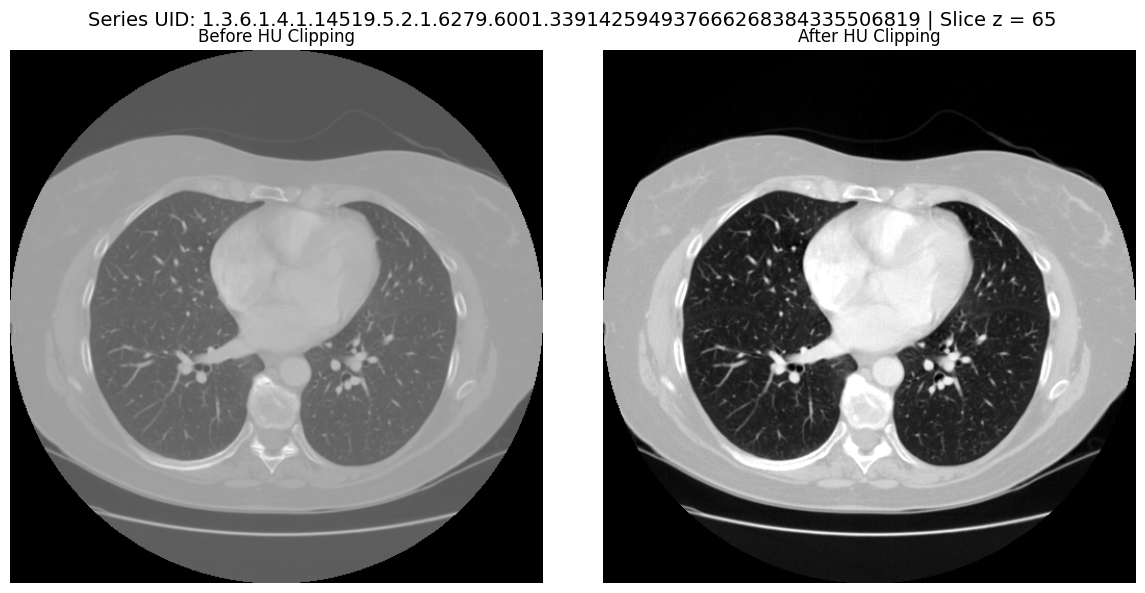

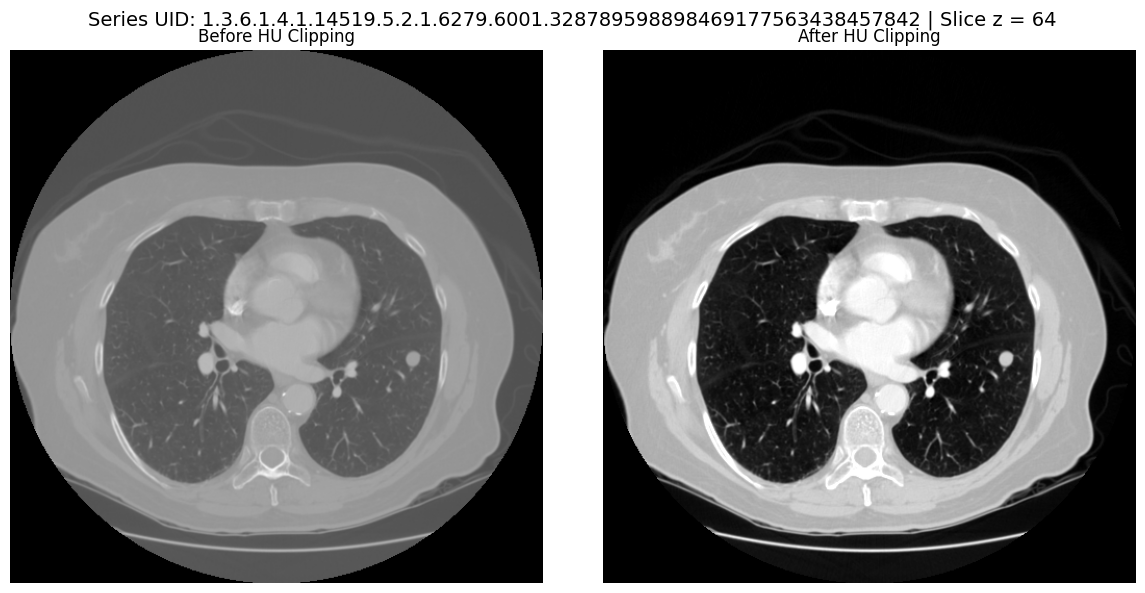

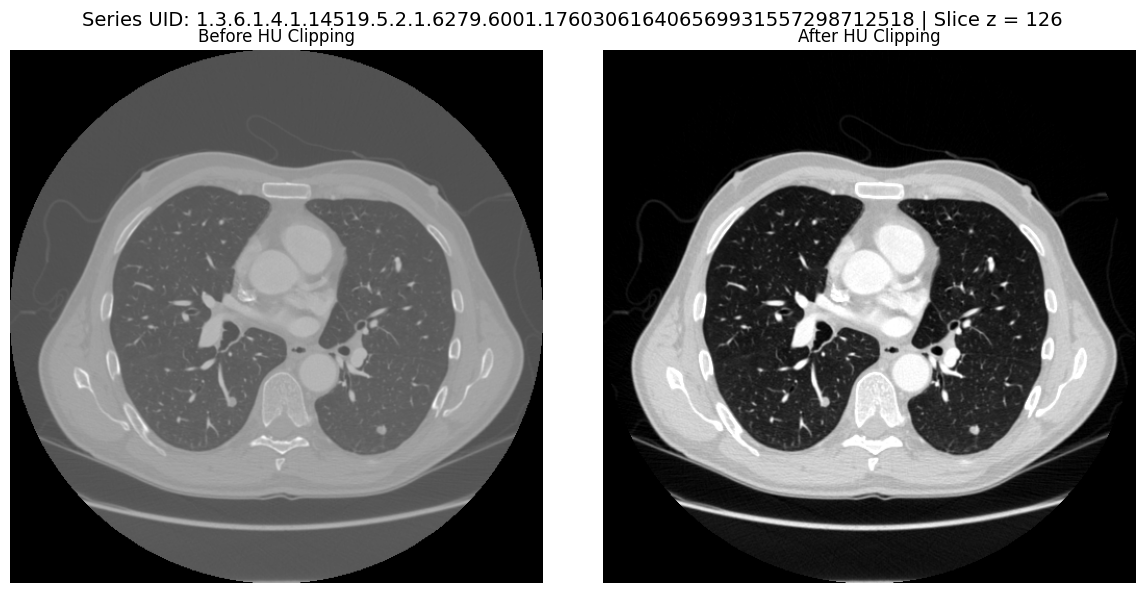

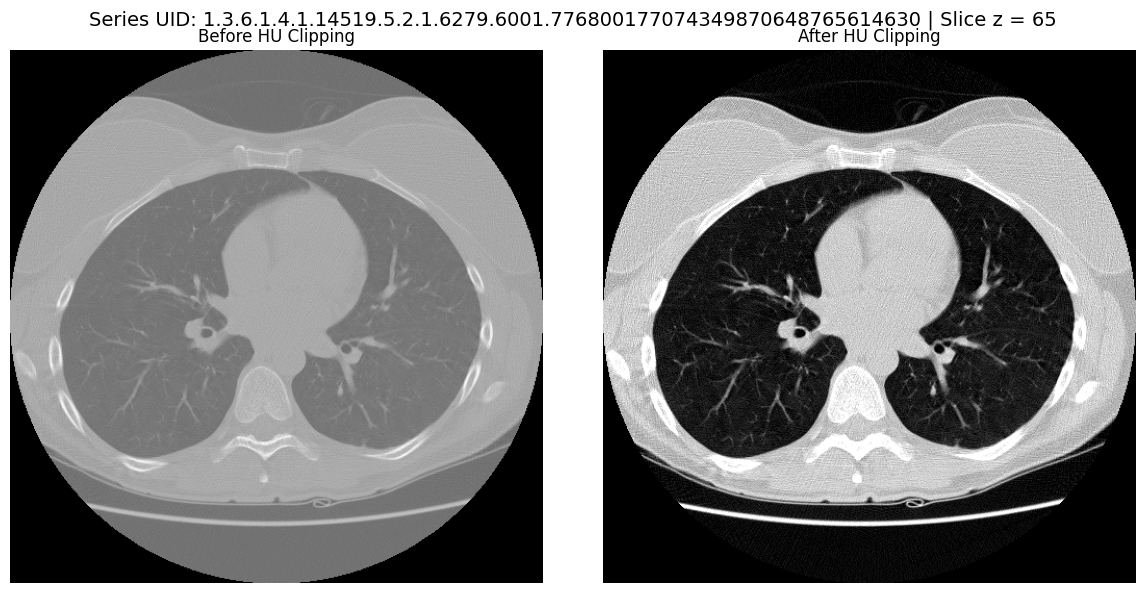

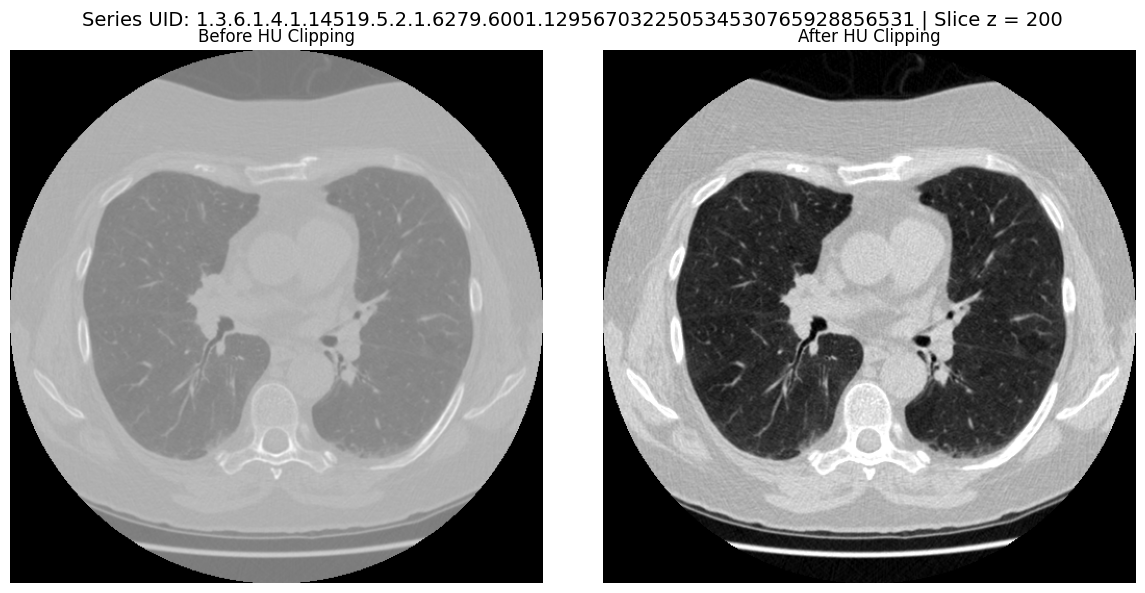

In [13]:
uids = [
    "1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819",  # 전체 후보 
    "1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842",  # 양성  1
    "1.3.6.1.4.1.14519.5.2.1.6279.6001.176030616406569931557298712518",  # 양성  2
    "1.3.6.1.4.1.14519.5.2.1.6279.6001.776800177074349870648765614630",  # 평균 결절 작 1
    "1.3.6.1.4.1.14519.5.2.1.6279.6001.129567032250534530765928856531",  # 평균 결절 작 2
]

for uid in uids:
    show_clip_comparison_from_mhd(uid)

In [14]:
def get_top_nodule_xyz(uid, n=1):
    cands = getCandidateInfoList()
    pos_list = [c for c in cands if c.series_uid == uid and c.isNodule_bool]
    if not pos_list:
        raise ValueError(f"No positive nodule found for UID: {uid}")
    # 결절 크기 기준 정렬 (큰 순서)
    pos_list.sort(key=lambda c: c.diameter_mm, reverse=True)
    return pos_list[n-1].center_xyz  # n번째로 큰 결절


def show_nodule_views(uid, center_xyz, zoom_size=48):
    # .mhd 경로 검색
    mhd_path = glob.glob(f'data-unversioned/part2/luna/subset*/{uid}.mhd')[0]
    ct_mhd = sitk.ReadImage(mhd_path)
    ct_np = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)

    # HU 클리핑
    ct_np = np.clip(ct_np, -1000, 1000)

    # 좌표 변환 (xyz → irc)
    origin = np.array(ct_mhd.GetOrigin())[::-1]
    spacing = np.array(ct_mhd.GetSpacing())[::-1]
    center_irc = np.round((np.array(center_xyz)[::-1] - origin) / spacing).astype(int)
    index, row, col = center_irc

    # 시각화
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # 상단: 전체 보기
    axs[0, 0].imshow(ct_np[index], cmap='gray')
    axs[0, 0].set_title(f'Axial slice (index {index})')

    axs[0, 1].imshow(ct_np[:, row, :], cmap='gray')
    axs[0, 1].set_title(f'Coronal slice (row {row})')

    axs[0, 2].imshow(ct_np[:, :, col], cmap='gray')
    axs[0, 2].set_title(f'Sagittal slice (col {col})')

    # 하단: 확대 보기
    axs[1, 0].imshow(ct_np[index,
                           row - zoom_size // 2:row + zoom_size // 2,
                           col - zoom_size // 2:col + zoom_size // 2],
                    cmap='gray')
    axs[1, 0].set_title(f'Axial zoom (index {index})')

    axs[1, 1].imshow(ct_np[index - zoom_size // 2:index + zoom_size // 2,
                           row,
                           col - zoom_size // 2:col + zoom_size // 2],
                    cmap='gray')
    axs[1, 1].set_title(f'Coronal zoom (row {row})')

    axs[1, 2].imshow(ct_np[index - zoom_size // 2:index + zoom_size // 2,
                           row - zoom_size // 2:row + zoom_size // 2,
                           col],
                    cmap='gray')
    axs[1, 2].set_title(f'Sagittal zoom (col {col})')

    for ax in axs.flatten():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

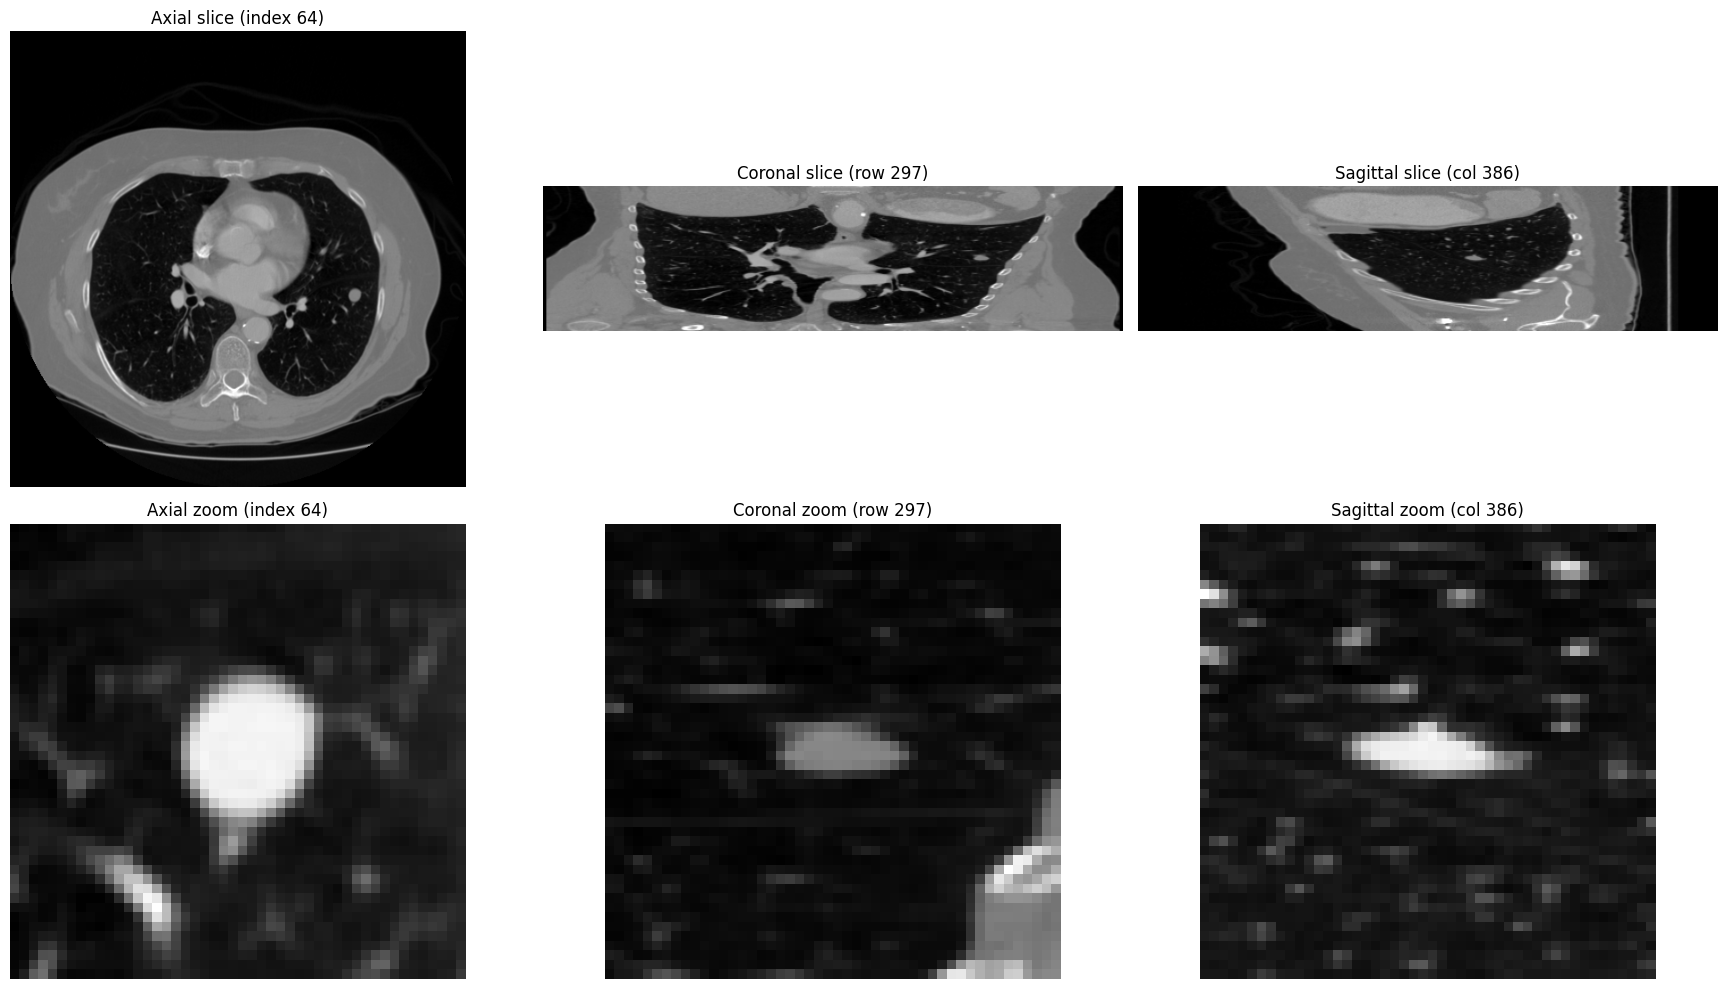

In [15]:
uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842'

# big nodule
center_xyz_top = get_top_nodule_xyz(uid, n=1)
show_nodule_views(uid, center_xyz_top)

In [16]:
def visualize_augmented_crops(uid, center_xyz, ds_list, augmentation_list, zoom=48):
    from p2ch12.dsets import getCt
    from util.util import xyz2irc

    # 원본 CT에서 IRC 좌표 변환
    ct = getCt(uid)
    center_irc = xyz2irc(center_xyz, ct.origin_xyz, ct.vxSize_xyz, np.eye(3))
    index, row, col = [int(round(x)) for x in center_irc]

    num_augs = len(ds_list)
    cols = 3
    rows = (num_augs + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    for i, ((title_str, _), ds) in enumerate(zip(augmentation_list, ds_list)):
        ax = axs[i // cols, i % cols]

        # candidate 중 중심좌표와 가장 가까운 것 선택
        cand_list = [c for c in ds.candidateInfo_list if c.series_uid == uid and c.isNodule_bool]
        if not cand_list:
            print(f"[{title_str}] No candidate found for {uid}")
            continue
        cand = min(cand_list, key=lambda c: np.linalg.norm(np.array(c.center_xyz) - np.array(center_xyz)))
        ct_tensor = ds[cand_list.index(cand)][0][0]  # (D, H, W)

        z = ct_tensor.shape[0] // 2
        y = ct_tensor.shape[1] // 2
        x = ct_tensor.shape[2] // 2

        crop = ct_tensor[z, y - zoom//2:y + zoom//2, x - zoom//2:x + zoom//2]
        ax.imshow(crop, cmap='gray')
        ax.set_title(title_str)
        ax.axis('off')

    # 나머지 subplot 비우기
    for j in range(i + 1, rows * cols):
        axs[j // cols, j % cols].axis('off')

    plt.tight_layout()
    plt.show()

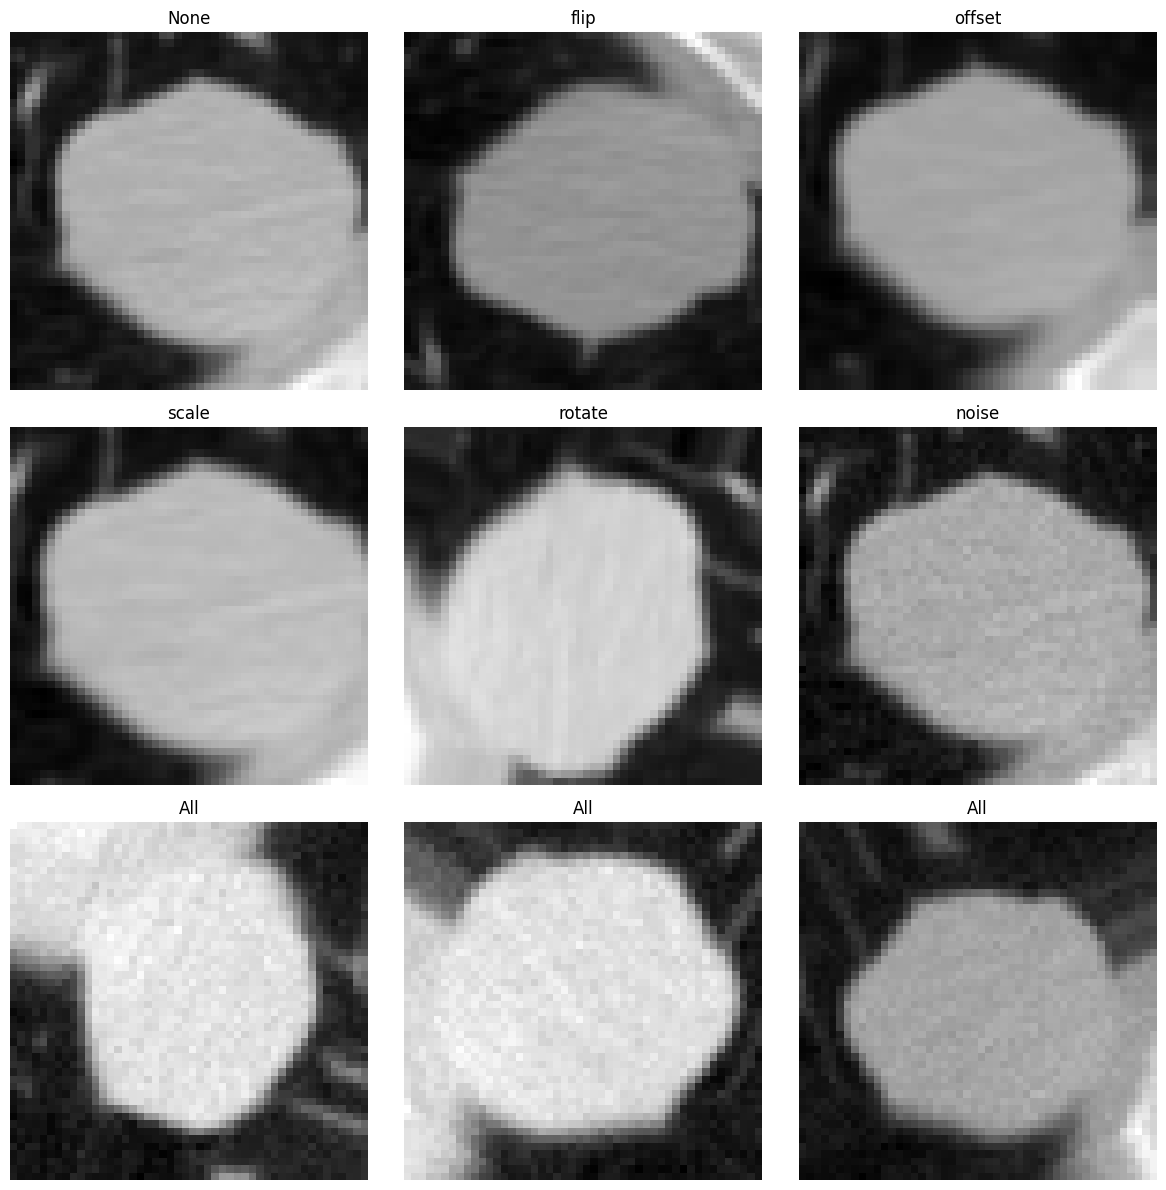

In [17]:
uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842'
center_xyz = get_top_nodule_xyz(uid, n=1)

visualize_augmented_crops(uid, center_xyz, ds_list, augmentation_list)

In [ ]:
def visualize_pos_neg_crop(uid, zoom=48):
    from p2ch12.dsets import getCandidateInfoList, getCt
    from util.util import xyz2irc
    import numpy as np
    import matplotlib.pyplot as plt

    cand_list = getCandidateInfoList()
    pos_list = [c for c in cand_list if c.series_uid == uid and c.isNodule_bool]
    neg_list = [c for c in cand_list if c.series_uid == uid and not c.isNodule_bool]


    ct = getCt(uid)

    def get_crop(cand):
        center_irc = xyz2irc(cand.center_xyz, ct.origin_xyz, ct.vxSize_xyz, np.eye(3))
        index, row, col = [int(round(v)) for v in center_irc]
        crop = ct.hu_a[index,
                       row - zoom//2 : row + zoom//2,
                       col - zoom//2 : col + zoom//2]
        return crop, index, row, col, cand.diameter_mm

    # 양성 상위 3개 (결절 크기 기준)
    pos_top3 = sorted(pos_list, key=lambda c: c.diameter_mm, reverse=True)[:3]
    # 음성 상위 3개 (결절처럼 보일 가능성 높은 것)
    neg_top3 = sorted(neg_list, key=lambda c: c.diameter_mm, reverse=True)[5:8]

    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # 양성 시각화 (위쪽 행)
    for i, cand in enumerate(pos_top3):
        crop, z, r, c, dia = get_crop(cand)
        axs[0, i].imshow(crop, cmap='gray', vmin=-1000, vmax=300)
        axs[0, i].set_title(f"Positive #{i+1}\n{dia:.1f} mm", fontsize=10)
        axs[0, i].axis('off')

    # 음성 시각화 (아래쪽 행)
    for i, cand in enumerate(neg_top3):
        crop, z, r, c, dia = get_crop(cand)
        axs[1, i].imshow(crop, cmap='gray', vmin=-1000, vmax=300)
        axs[1, i].set_title(f"Negative #{i+1}\n{dia:.1f} mm", fontsize=10)
        axs[1, i].axis('off')

    plt.suptitle(f"Positive vs Negative Candidates - UID: {uid}", fontsize=14)
    plt.tight_layout()
    plt.show()

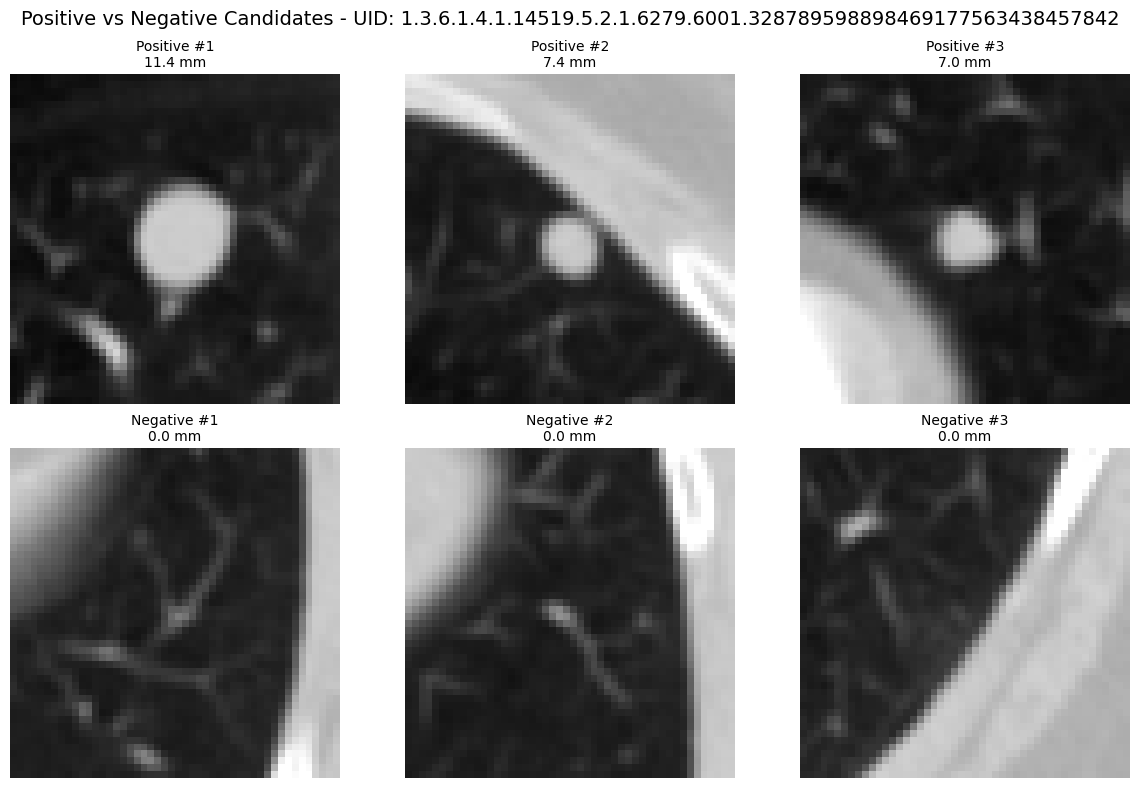

In [19]:
uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842'
visualize_pos_neg_crop(uid)

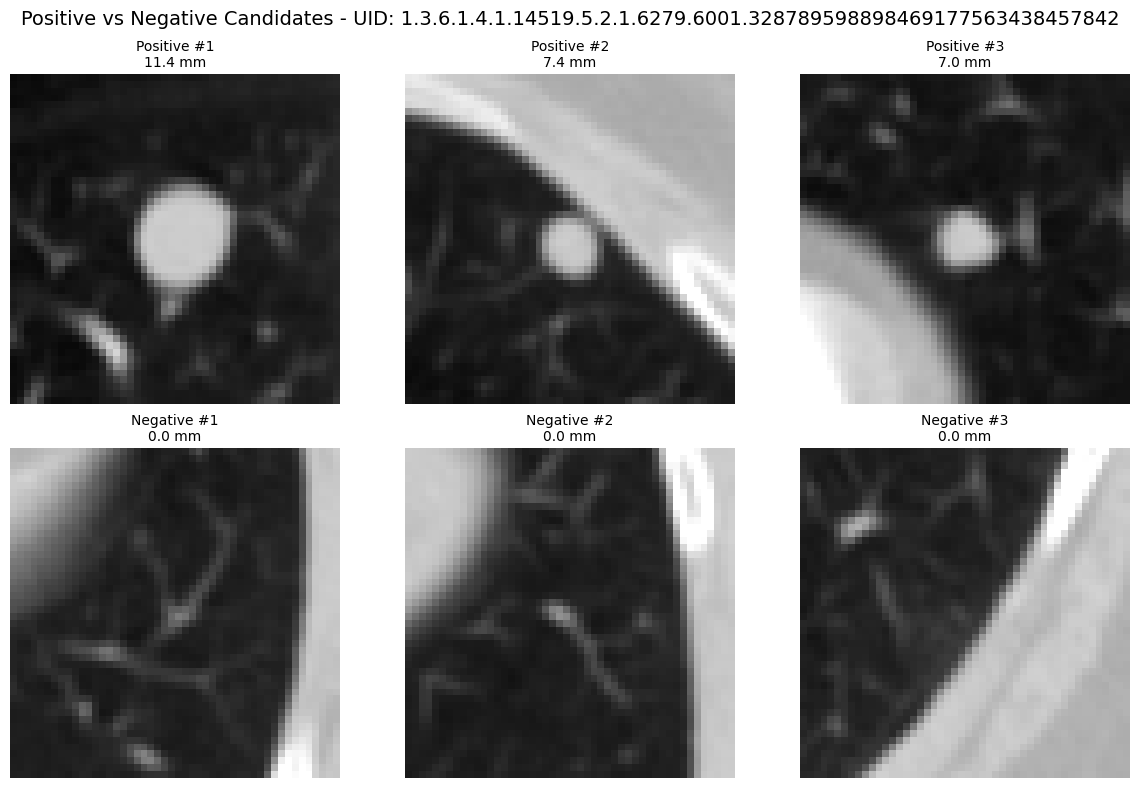

In [20]:
uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.328789598898469177563438457842'
visualize_pos_neg_crop(uid)